<a href="https://colab.research.google.com/github/slimf1/ZZ3-DL/blob/main/04_autoencoder_debruitage_Keras_etud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencodeur 

Objectif : construire un autoencodeur de débruitage en utilisant Keras :
- On bruite l'entrée
- La sortie est l'image non bruitée
Utilisation du mode Sequentiel

## MNIST 

La base de données MNIST (Mixed National Institute of Standards and Technology), est une base de données de chiffres manuscrits. C’est une base de données standard pour le test de nouveaux algorithmes de reconnaissance de ces chiffres. Elle est composée de 60000 images d’apprentissage et 10000 images de test. Les images en noir et blanc, normalisées centrées de 28 pixels de côté.

![mnist.png](./mnist.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras as tk
from tensorflow.keras.datasets import mnist

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

On charge ensuite les données MNIST. Les paramètres de la base sont récupérés (nombre d'exemples, de classes, taille de la rétine).

11501568/11490434 [==============================] - 0s 0us/step


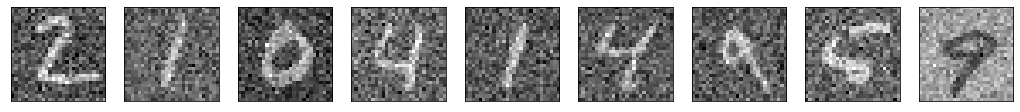

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


num_examples = x_train.shape[0] 
num_test = x_test.shape[0]
num_input = x_train.shape[1]*x_train.shape[2]
num_classes = 10

img_size = x_train.shape[1] 
img_shape = (img_size, img_size)


# Normalisation
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Bruit Gaussien
def gaussian_noise(vector_dim, mu=0, sigma=0.3):
    return np.random.normal(mu, sigma, vector_dim * 28 * 28).reshape((vector_dim, 28, 28, 1)) 
x_test_bruitee = x_test + gaussian_noise(len(x_test))
x_train_bruitee = x_train + gaussian_noise(len(x_train))

plt.figure(figsize=(20, 2))
for i in range(1,10):
    ax = plt.subplot(1, 10, i)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_bruitee[i].reshape(28, 28), cmap="binary")
plt.show()

https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/

## Autoencodeur à couches convolutives


In [3]:
batch_size = 256
num_epochs = 5

model = tk.models.Sequential()
model.add(tk.layers.Input((28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", strides=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", strides=1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", strides=1))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", strides=1))
model.add(UpSampling2D(size=(2, 2)))
model.add(Conv2D(1, kernel_size=(3, 3), activation="sigmoid", padding="same", strides=1))


In [4]:
model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy',metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

Epoch 1/5
235/235 [==============================] - 38s 30ms/step - loss: 0.1563 - acc: 0.8079 - val_loss: 0.0953 - val_acc: 0.8128
Epoch 2/5
235/235 [==============================] - 7s 28ms/step - loss: 0.0918 - acc: 0.8139 - val_loss: 0.0875 - val_acc: 0.8132

Epoch 0 Précision :0.814 


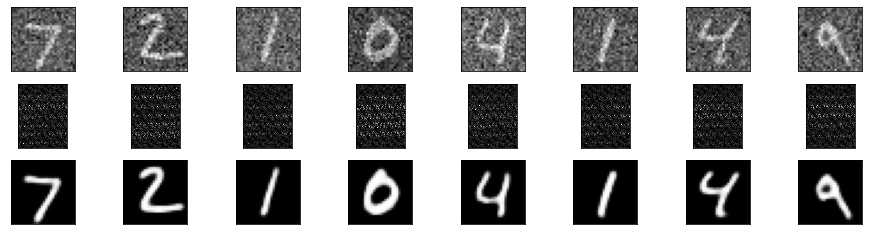

Epoch 3/5
235/235 [==============================] - 7s 28ms/step - loss: 0.0869 - acc: 0.8144 - val_loss: 0.0846 - val_acc: 0.8137
Epoch 4/5
235/235 [==============================] - 7s 28ms/step - loss: 0.0845 - acc: 0.8146 - val_loss: 0.0828 - val_acc: 0.8138

Epoch 2 Précision :0.815 


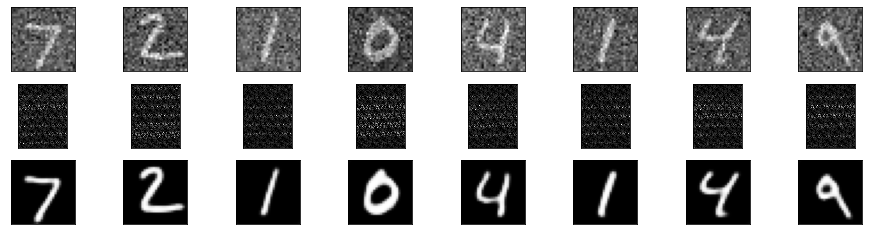

Epoch 5/5
235/235 [==============================] - 7s 29ms/step - loss: 0.0830 - acc: 0.8148 - val_loss: 0.0815 - val_acc: 0.8138
INFO:tensorflow:Assets written to: autoencodeur_debruitage.model/assets


In [5]:
from tensorflow.keras import backend as K
class myCallback(tk.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        encoder = K.function([model.layers[0].input],[model.layers[3].output])
        if((epoch-1) % 2==0):   
            print("\nEpoch {0:d} Précision :{1:5.3f} ".format(epoch-1,logs.get('acc') ))
            decoded_imgs = model.predict(x_test)
            encoded_imgs = encoder([x_test_bruitee])[0]


            n = 8  
            plt.figure(figsize=(40, 4))
            for i in range(n):
                ax = plt.subplot(3, 20, i + 1)
                plt.imshow(x_test_bruitee[i].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(3, 20, i + 1 + 20)
                plt.imshow(encoded_imgs[i].reshape(64,49))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

                ax = plt.subplot(3, 20, 2*20 +i+ 1)
                plt.imshow(decoded_imgs[i].reshape(28, 28))
                plt.gray()
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

            plt.show()

            
callbacks = myCallback()
model.fit(x_train_bruitee,x_train,epochs=num_epochs,batch_size=batch_size,validation_data=(x_test_bruitee, x_test),callbacks=[callbacks])
model.save('autoencodeur_debruitage.model')


In [6]:
model.evaluate(x_test_bruitee, x_test)


313/313 [==============================] - 1s 5ms/step - loss: 0.0815 - acc: 0.8138


[0.08154284954071045, 0.8138324022293091]

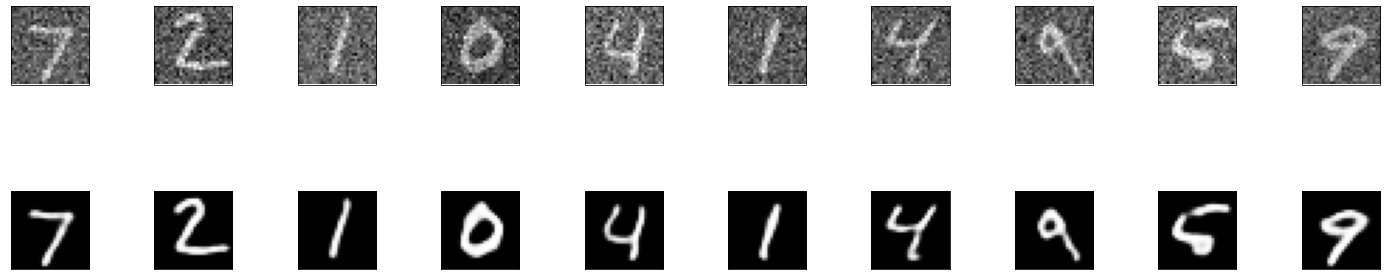

In [7]:
img_debruitee = model.predict(x_test_bruitee)
plt.figure(figsize=(40, 4))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(x_test_bruitee[i].reshape(28, 28))
    
    ax = plt.subplot(3, 20, 40 +i+ 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img_debruitee[i].reshape(28, 28))

plt.tight_layout()